# Figures for DSTRF Paper

## Setup

In [184]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import yaml

from dstrf import strf, mle, io, performance, spikes
import mat_neuron._model as mat

# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import matplotlib as plt
import seaborn as sns           # data visualization package
from analysis_fns import load_emdat, load_mldat, make_mlob

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

figroot = "/home/tyler/dstrf_results/figures/"
savefigs = True

yfile = "../../scripts/modeldata.yml"
with open(yfile,"r") as yf:
    config = yaml.load(yf)

# set variables based on `config`
ntaus = len(config["mat"]["taus"])
mat_fixed = np.asanyarray(config["mat"]["taus"] + [config["mat"]["refract"]],dtype='d')
upsample = int(config["strf"]["stim_dt"] / config["mat"]["model_dt"])
kcosbas = strf.cosbasis(config["strf"]["ntau"], config["strf"]["ntbas"])
ntbas = kcosbas.shape[1]
upsample = int(config["strf"]["stim_dt"] / config["mat"]["model_dt"])

In [2]:
%%time
# load data
select = ["posp","tonic", "phasic"]
data = {}

for s in select:
    res, mp = load_emdat(s,EOcut=0.2,CORcut=0.2,root='/home/tyler/dstrf_results/modeldata/')
    data[s] = {"results": res,
               "map": mp}

CPU times: user 208 ms, sys: 148 ms, total: 356 ms
Wall time: 502 ms


In [23]:
def gridstyle(ax,grid=True):
    for spine in ax.spines.values():
        spine.set_edgecolor("lightgray")
        spine.set_linewidth(0)
        
    for i,l in enumerate(ax.yaxis.get_ticklines()):
        l.set_color("lightgray")
        
    for l in ax.xaxis.get_ticklines():
        l.set_color("lightgray")
        
    if grid: 
        ax.spines['bottom'].set_visible(False)
        ax.grid("on","both")
        axvline(0,color="lightgray",linewidth=2,zorder=1)
        axhline(0,color="lightgray",linewidth=2,zorder=1)

## 1: Concept figure
- biophysical model: piping song through RF and biophysics to generate spike trains
- phenomenological model: estimating RF and linear history terms + model 
- prediction of response
- How the model works?
- Side-by-side start with generative model
- Receptive field sub for dendritic tree, spike generation part, mapped onto little neuron cartoon
- Could even be a real example. 

## 2: Estimated vs true
- rows: same RF, different dynamics (posp, tonic, phasic)
- columns: same dynamics, different RFs (broadband fast, broadband slow, narrowband)
- show true RF, estimated RF, true spike trains, predicted spike trains.
- Quantify posterior overlap of RFs vs parameter estimates?
- In bottom row, show estimated w/a1/a2 values with posteriors for parameter estimates - corner plot or just a1 vs a2
- Pick out good exemplars 
- Grid RF in columns, posp/tonic/phasic in rows
- Show true and estimated RF
- RFs: broadband fast, broadband slow, narrow band

In [3]:
def model_cell_str(m,n):
    s = "{}-rs-{}" if m == "posp" else "b-{}-{}"
    c = s.format(m,n)
    return c

def get_results(m,n):
    cell = model_cell_str(m,n)
    w1 = data[m]["results"][cell]["w1"]
    chain = data[m]["results"][cell]["chain"][-500:,:]
    mlest, mltest, adata, tdata = make_mlob(cell)
    est_rf = strf.from_basis(mltest.strf(w1),kcosbas)
    results =        { "w1": w1,
                        "chain": chain,
                        "mlest": mlest,
                        "mltest": mltest,
                        "est_rf": est_rf,
                        "assim_data": adata,
                        "test_data": tdata
                      }              
    return results

In [4]:
hm_cmap = "RdBu_r"

sns.set_style("ticks")
sns.set_context("notebook")

plt.rcParams.update({'text.color' : "dimgray",
                     'axes.labelcolor' : "dimgray",
                     'axes.edgecolor' : "gray",
                     'ytick.color' : "gray",
                     'xtick.color' : "gray"
                    })

data_clr = "black"
est_clr = ["darkcyan","darkmagenta","goldenrod"]

def ticks_off():
    xticks([])
    yticks([])

def get_as(model,nums):
    a1 = []
    a2 = []
    for n in nums:
        cell= model_cell_str(model,n)
        a1.append(cell_data[cell]["chain"][-500:,1])
        a2.append(cell_data[cell]["chain"][-500:,2])
    return a1, a2


def despine(ax,x=True,y=True):     
    if x:
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)
   
    if y:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

matlabs =  [r'$\omega$',r'$\alpha_1$',r'$\alpha_2$']

mrange=[[  -0.1  , 20  ],
        [-5.1, 25.1],
        [ -1.1,  1.1]],

slimrange=[[  -1  , 10.1  ],
           [-2.6, 2.6],
           [ -0.51,  0.51]],

In [82]:
ccolors = [(0,0.3,0.3),(0,0.6,0.6),(0,0.9,0.9)]
mcolors = [(0.3,0.3,0),(0.6,0.6,0),(0.9,0.9,0)]
ycolors = [(0.3,0,0.3),(0.6,0,0.6),(0.9,0,0.9)]

est_clr = ["darkcyan", "darkmagenta", "goldenrod"]

In [6]:
cell_data = {}

In [7]:
%%time
rootstr = "/scratch/dmeliza/modeldata/SNR4posp-norm/{}/rf.npz"
#cell_data = {}
cell_nums = [4,14,24]
models = ["posp","tonic","phasic"]

for m in models:
    for n in cell_nums:
        cell = model_cell_str(m,n)
        if cell not in cell_data: cell_data[cell] = get_results(m,n)

CPU times: user 1min 42s, sys: 19min 43s, total: 21min 26s
Wall time: 22min 8s


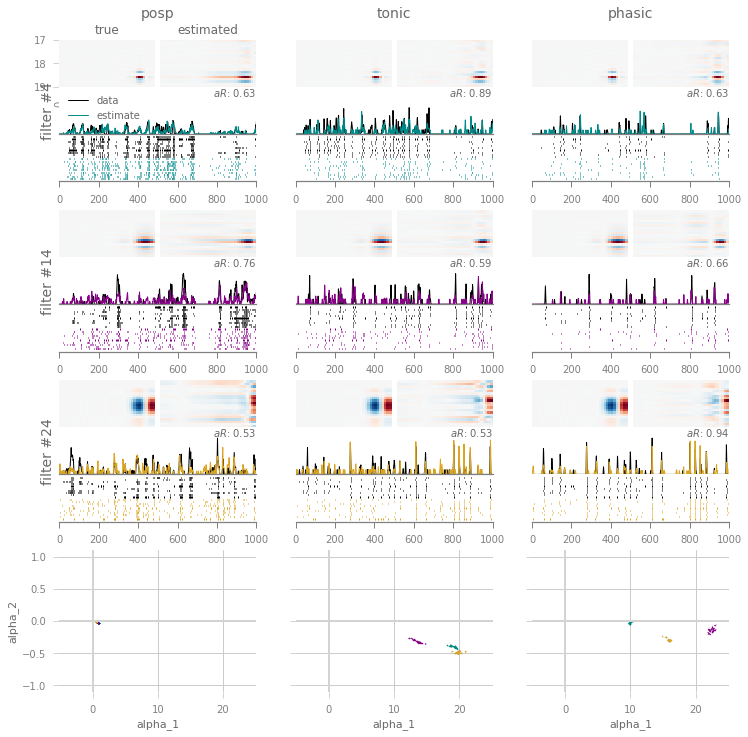

In [185]:
from matplotlib import gridspec

duration = 1000
fig = figure(2, figsize=(12, 12))
outer = gridspec.GridSpec(4, 3, wspace=0.2, hspace=0.2)

for i, m in enumerate(models):
    for j, n in enumerate(cell_nums):
        inner = gridspec.GridSpecFromSubplotSpec(3, 2,
                    subplot_spec=outer[i+3*j], wspace=0.05, hspace=0,height_ratios=[1,1,1])
    
        cell = model_cell_str(m,n)

        # plot true rf
        true_rf_plt = inner.new_subplotspec((0,0))
        ax = subplot(true_rf_plt)
        gridstyle(ax,grid=False)
        true_rf = np.load(rootstr.format(cell))["rf"]
        rsmpl_rf = np.fliplr(sp.signal.resample(sp.signal.resample(true_rf,20),40,axis=1))
        rsmpl_rf = np.vstack((np.zeros((3,40)), rsmpl_rf[:-3,:]))
        rsmpl_rf = np.hstack((np.zeros((20,3)), rsmpl_rf[:,:-3]))

        sns.heatmap(rsmpl_rf,cbar=False,cmap=hm_cmap,ax=ax)

        if i+j == 0: 
            ax.set_title("true")
            ax.set_yticks([0,10,20])
            ax.set_xticks([0,20,40])
        else:
            axis("off")
       # if j == 0: 
       #     t = ax.text(0,0,m)
       #     t.set_ha('center')
       #     t.set_va('top')

        fig.add_subplot(ax)

        # plot estimated rf
        est_rf_plt = inner.new_subplotspec((0,1))
        ax = subplot(est_rf_plt)
        sns.heatmap(cell_data[cell]["est_rf"],cbar=False,cmap=hm_cmap,ax=ax)
        ticks_off()
        if i+j == 0: ax.set_title("estimated")
        axis("off")
        fig.add_subplot(ax)

        # plot spike rasters
        spikes_plt = inner.new_subplotspec((2,0),colspan=2)
        n_ppost = 10
        samples = np.random.permutation(config["emcee"]["nwalkers"])[:n_ppost]
        mltest = cell_data[cell]["mltest"]
        test_data = cell_data[cell]["test_data"]
        w1 = cell_data[cell]["w1"]
        chain = cell_data[cell]["chain"]

        spk_plt = inner.new_subplotspec((2,0),colspan=2)
        ax = subplot(spk_plt)

        all_spks = []
        for k, idx in enumerate(samples):
            mparam = chain[idx]
            V_mc = mltest.V(mparam)
            spk = mltest.predict(mparam,mat_fixed,V_mc)
            spk_t = spk.nonzero()[0]
            ax.vlines(spk_t * config["mat"]["model_dt"] / config["strf"]["stim_dt"],
                   k, k + 0.5,linewidth=1,color=est_clr[j])
            all_spks.append(spk)

        for l, spk in enumerate(test_data["spike_t"]):
            ax.vlines(spk * config["mat"]["model_dt"] / config["strf"]["stim_dt"],
                    l + k + 1, l + k + 1.5, data_clr,linewidth=1)
        ax.set_yticks([])
        ax.set_xlim(0,duration)
        sns.despine(left=True)  
        fig.add_subplot(ax)

        # plot psths
        spk_plt = inner.new_subplotspec((1,0),colspan=2)
        ax = subplot(spk_plt)
        psth = spikes.psth(np.asarray(all_spks).T,upsample,1)
        test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
        mx = np.max([psth,test_psth])
        ax.plot(test_psth/mx,linewidth=1,color=data_clr,label="data")
        ax.plot(psth/mx,linewidth=1,color=est_clr[j],label="estimate")
        eo = data[m]["results"][cell]["corr"].tolist() / data[m]["results"][cell]["eo"].tolist()
        #plot([],[],' ',label="$R$: {:.2f}".format(eo))
        if i+j == 0: ax.legend(["data","estimate"],loc="upper left")
        t = ax.text(duration,1.04,"$aR$: {:.2f}".format(eo),fontsize=10)
        t.set_ha("right")
        ax.set_xlim(0,duration)
        ax.set_ylim(0,1.3)

        if i == 0: 
            ax.set_ylabel("filter #{}".format(n),fontsize=14)
        if j == 0:
            t = ax.text(duration/2,3.2,m,fontsize=14)
            t.set_ha("center")
            
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        fig.add_subplot(ax)

for i, m in enumerate(models):    
    a1, a2 = get_as(m, cell_nums)
    bottom = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[i+9], wspace=0, hspace=0,
                                              height_ratios=[0.2,1],
                                              width_ratios=[1,0.2])
    ax = subplot(outer[i+9])
    gridstyle(ax)
    for j in range(3):
        ax.scatter(a1[j],a2[j],alpha=0.1,s=1,color=est_clr[j])
    ax.set_xlabel("alpha_1")
    ax.set_xlim(mrange[0][1])
        
    if i==0: 
        ax.set_ylabel("alpha_2")
    else:
        ax.set_yticklabels([""])
        #ax.spines['left'].set_visible(False)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(mrange[0][2])
    ax.tick_params(top="off")
    
if savefigs: savefig(figroot+"fig2_modeldata_exmaples.pdf",transparent=True)

## 3: Population distribution
- corner plot of parameters
- panel showing adjusted R for three different dynamics
- possibly show how omega varies with RF parameters
- Maybe add panel with adjusted R, establish that it works
- See if we can figure out the souce of varation in omega, add another subplot

In [21]:
def crnplt(data,label="",hist=True,mrange=None,labs=[r'$\omega$',r'$\alpha_1$',r'$\alpha_2$'],bins=None,kde_kws=None):
    for i in range(3):
        for j in range(3):
            if j > i: break
            ax = subplot(4,3,3*i+j+1)
            if i == j:
                gridstyle(ax,False)
                sns.distplot(data[:,j],hist=hist,label=label,bins=bins,kde_kws=kde_kws)
                if mrange:
                    xlim(mrange[0][i])
                if i == 0 and j == 0: legend()
                else: legend().set_visible(False)
                despine(ax,x=False)
            
            else:
                gridstyle(ax)
                plot(data[:,j],data[:,i],'.',alpha=0.5,markersize=10)
                despine(ax,x=False,y=False)

                if mrange:
                    xlim(mrange[0][j])
                    ylim(mrange[0][i])
            
                
            xticks(rotation=45)    
            if 3*i+j == 3: ylabel(labs[1]);
            if 3*i+j == 6: ylabel(labs[2])
            if 3*i+j == 0: ylabel(labs[0])
            if 3*i+j == 7: xlabel(labs[1])
            if 3*i+j == 8: xlabel(labs[2])
            if 3*i+j == 6: xlabel(labs[0])
                
    
    tight_layout()
 

In [33]:
import csv
csvdata = {}

with open("/scratch/mcb2x/modeldata/SNR4syn-update.csv") as datacsv:
    reader = csv.reader(datacsv)
    for row in reader:
        cell = model_cell_str(row[0],row[1])
        csvdata[cell] = row[-3]

tstff = []
pstff = []
ostff = []
grtr = []
lss = []
for s in models:
    for k in data[s]["results"].keys():
        if k in data[s]["results"].keys():
            w1 = data[s]["results"][k]["w1"]
            if abs(w1[0]) < 15:
                rf = np.load(rootstr.format(k))["rf"]
                
                try:
                    if s == "phasic": pstff.append([w1[0],csvdata[k]])
                    if s == "tonic": tstff.append([w1[0],csvdata[k]])
                    if s == "posp": ostff.append([w1[0],csvdata[model_cell_str("phasic",k.split("-")[-1])]])


                    if w1[0] < 9:
                        lss.append(rf)
                    else:
                        grtr.append(rf)
                except:
                    pass
pstff = np.asarray(pstff,dtype=float)
tstff = np.asarray(tstff,dtype=float)
ostff = np.asarray(ostff,dtype=float)

In [ ]:
fig = figure(3, figsize=(12, 10))
   
# make corner plot
#sns.set_style("ticks")
#sns.set_palette("cubehelix",len(select))
sns.set_palette(est_clr)


HIST = False

for s in models:
    crnplt2(np.asarray(data[s]["map"]),s,mrange=mrange,labs=matlabs,hist=HIST)

suptitle("Population Parameter Distribution",y=1.04)

if savefigs: savefig(figroot+"fig3_modeldata_corner.pdf",transparent=True)


figure(figsize=(12,3))

ax = subplot2grid((2,6),(0,0),colspan=2,rowspan=2)
meds = []
for i,s in enumerate(models):
    eo = [data[s]["results"][m]["corr"] / data[s]["results"][m]["eo"].tolist() for m in data[s]["results"]]
    plot([i]*len(eo),eo,"o",alpha=0.1,markersize=5)
    meds.append(np.median(eo))
plot(meds,"--k",label="median",linewidth=1)
for i,m in enumerate(meds):
    plot([i],[m],"o")
ylim(0,1)
ylabel("Adjusted $R$")
xticks([0,1,2],select)
despine(ax,x=False,y=False)
legend()

ax = subplot2grid((2,6),(0,2),rowspan=2)

plot([0,1.5707],[np.median(ostff[np.where(ostff[:,1] < 1),0]),
                 np.median(ostff[np.where(ostff[:,1] > 1),0])],color=est_clr[0],linestyle="--",linewidth=1)

plot([0,1.5707],[np.median(tstff[np.where(tstff[:,1] < 1),0]),
                 np.median(tstff[np.where(tstff[:,1] > 1),0])],color=est_clr[1],linestyle="--",linewidth=1)

plot([0,1.5707],[np.median(pstff[np.where(pstff[:,1] < 1),0]),
                 np.median(pstff[np.where(pstff[:,1] > 1),0])],color=est_clr[2],linestyle="--",linewidth=1)

scatter(ostff[:,1],ostff[:,0],color=est_clr[0],alpha=0.5,zorder=10)
scatter(tstff[:,1],tstff[:,0],color=est_clr[1],alpha=0.5,zorder=10)
scatter(pstff[:,1],pstff[:,0],color=est_clr[2],alpha=0.5,zorder=10)


xticks([0,1.5707],[0,"$\pi/2$"])
ylabel("$\omega$")
xlabel("rotation ($\phi$)")
despine(ax,x=False,y=False)


ax = subplot2grid((2,6),(0,3))
imshow(np.fliplr(grtr[4]),aspect="auto",cmap="RdBu_r")
xlabel("$\phi = 0$")
despine(ax)

ax = subplot2grid((2,6),(1,3))
imshow(np.fliplr(lss[-1]),aspect="auto",cmap="RdBu_r")
xlabel("$\phi = \pi/2$")
despine(ax)

tight_layout()

if savefigs: savefig(figroot+"fig3_modeldata_corner_bottom.pdf",transparent=True)

## 4: Example(s) of crcns
- one or two examples, from different brain regions, with good fit
- adapt the structure of Figure 1

In [54]:
%%time
cmresem, cmmpem = load_emdat("cm",EOcut=0.2,CORcut=0.2,root='/home/tyler/dstrf_results/crcns/')
cmresml, cmmpml = load_mldat("cm",EOcut=0.2,CORcut=0.2,root='/home/tyler/dstrf_results/crcns/')

CPU times: user 4min 54s, sys: 2min 14s, total: 7min 8s
Wall time: 7min 8s
Compiler : 152 ms


In [73]:
sns.set_palette("tab10",7)

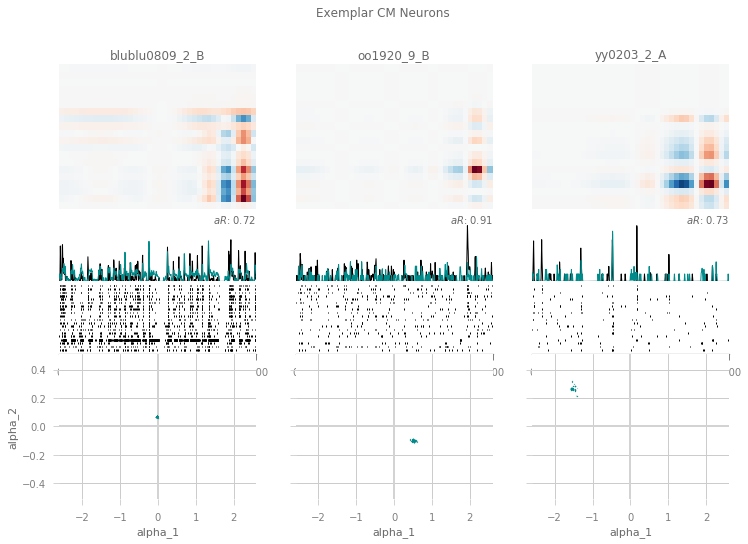

In [191]:
cm_select = ['blublu0809_2_B','oo1920_9_B', 'yy0203_2_A']

fig = figure(4, figsize=(12, 8))
grid = gridspec.GridSpec(5, 3, wspace=0.2, hspace=0, height_ratios=[1,0.5,0.5,1])
for i,c in enumerate(cm_select):
    
    # strf estimate
    ax = subplot(grid[i])
    sns.heatmap(cmresem[c]["rf_map"],cbar=False,cmap=hm_cmap,ax=ax)
    ticks_off()
    ax.set_title(c)
    #if i == 0: ax.set_ylabel("estimated strf")
    #axis("off")
    fig.add_subplot(ax)

    # plot spike rasters
    ax = subplot(grid[i+6])
    n_ppost = 10
    samples = np.random.permutation(config["emcee"]["nwalkers"])[:n_ppost]
    mltest = cmresml[c]["mltest"]
    test_data = cmresml[c]["test_data"]
    w1 = cmresem[c]["w1"]
    chain = cmresem[c]["chain"]

    all_spks = []
    for k, idx in enumerate(samples):
        mparam = chain[idx]
        V_mc = mltest.V(mparam)
        spk = mltest.predict(mparam,mat_fixed,V_mc)
        spk_t = spk.nonzero()[0]
        ax.vlines(spk_t * config["mat"]["model_dt"] / config["strf"]["stim_dt"],
               k, k + 0.5,linewidth=1)
        all_spks.append(spk)  
        
    for l, spk in enumerate(test_data["spike_t"]):
        ax.vlines(spk * config["mat"]["model_dt"] / config["strf"]["stim_dt"],
                l + k + 1, l + k + 1.5, data_clr,linewidth=1)
    duration = len(V_mc)
    duration = 1000
    ax.set_yticks([])
    ax.set_xlim(0,duration)
        
    despine(ax,x=False)
    fig.add_subplot(ax)

    # plot psths
    ax = subplot(grid[i+3])
    psth = spikes.psth(np.asarray(all_spks).T,upsample,1)
    test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
    mx = np.max([psth,test_psth])
    ax.plot(test_psth/mx,linewidth=1,color=data_clr,label="data")
    ax.plot(psth/mx,linewidth=1,label="estimate")
    eo = cmresem[c]["corr"].tolist() /  cmresem[c]["eo"].tolist()
    #plot([],[],' ',label="$R$: {:.2f}".format(eo))
    if i+j == 0: ax.legend(["data","estimate"],loc="upper left")
    t = ax.text(duration,1.04,"$aR$: {:.2f}".format(eo),fontsize=10)
    t.set_ha("right")
    ax.set_xlim(0,duration)
    ax.set_ylim(0,1.3)
    despine(ax)
    fig.add_subplot(ax)
    

   # bottom = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=grid[i+12], wspace=0, hspace=0,
   #                                           height_ratios=[0.2,1],
   #                                           width_ratios=[1,0.2])
    #ax = subplot(bottom[0])
    #subplot(4,3,10)
    a1 = cmresem[c]["chain"][-500:,1]
    a2 = cmresem[c]["chain"][-500:,2]

    #ax.hist(a1,bins=10,color=est_clr[0])
    #ax.set_xlim(slimrange[0][1])
    #ax.axis("off")

    '''
    ax = subplot(bottom[3])
    ax.hist(a2,bins=10,orientation="horizontal",color=est_clr[0])
    ax.set_ylim(slimrange[0][2])
    ax.axis("off")
    '''  

    ax = subplot(grid[i+9])
    gridstyle(ax)
    ax.scatter(a1,a2,alpha=0.1,s=1,zorder=10)
    ax.set_xlabel("alpha_1")
    ax.set_xlim(slimrange[0][1])
        
    if i==0: 
        ax.set_ylabel("alpha_2")
    else:
        ax.set_yticklabels([])
        #ax.spines['left'].set_visible(False)

    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.set_ylim(slimrange[0][2])
    ax.tick_params(top="off")
    
suptitle("Exemplar CM Neurons")
if savefigs: savefig(figroot+"fig4_cm_examples.pdf",transparent=True)

## 5: Crcns corner plot
- Show CM corner
- Point is to show that there is a bimodal distribution in CM

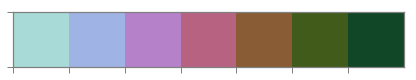

In [156]:
ch = sns.cubehelix_palette(7,rot=-1.5,start=300,hue=1,dark=0.2,light=0.8)
sns.palplot(ch)

In [74]:
def crnplt2(data,label="",hist=True,mrange=None,labs=[r'$\omega$',r'$\alpha_1$',r'$\alpha_2$'],bins=None,kde_kws=None,rows=3):
    for i in range(3):
        for j in range(3):
            if j > i: break
            ax = subplot(4,3,3*i+j+1)
            gridstyle(ax,False)
            # ax.tick_params(axis="both",color="lightgray")
            # ax.ticklabel_format()
            
            
            for spine in ax.spines.values():
               # spine.set_edgecolor("lightgray")
                spine.set_linewidth(0)
            
            if i == j: 
                for spine in ax.spines.values():
                   # spine.set_edgecolor("lightgray")
                    spine.set_linewidth(1)
                
                sns.distplot(data[:,j],hist=hist,label=label,bins=bins,kde_kws=kde_kws)
                if mrange:
                    xlim(mrange[0][i])
                if i == 0 and j == 0: legend()
                else: legend().set_visible(False)

                despine(ax,x=False)
                if j != 2:
                    ax.set_xticklabels([""])
                    
                ax.spines['bottom'].set_visible(True)
                #ax.grid("on")
                #[t.set_color('gray') for t in ax.xaxis.get_ticklabels()]

            else:
                plot(data[:,j],data[:,i],'.',alpha=0.8,markersize=10)
                despine(ax,x=False,y=False)
                
                
                if i != 2:
                    ax.set_xticklabels([])
                
                if j != 0:
                    ax.set_yticklabels([])
                
               # [t.set_color('gray') for t in ax.xaxis.get_ticklabels()]
               # [t.set_color('gray') for t in ax.yaxis.get_ticklabels()]
                
                gridstyle(ax)
                
                if mrange:
                    xlim(mrange[0][j])
                    ylim(mrange[0][i])
            
                
            xticks(rotation=45)    
            if 3*i+j == 3: ylabel(labs[1]);
            if 3*i+j == 6: ylabel(labs[2])
            if 3*i+j == 0: ylabel(labs[0])
            if 3*i+j == 7: xlabel(labs[1])
            if 3*i+j == 8: xlabel(labs[2])
            if 3*i+j == 6: xlabel(labs[0])
    
    #tight_layout()

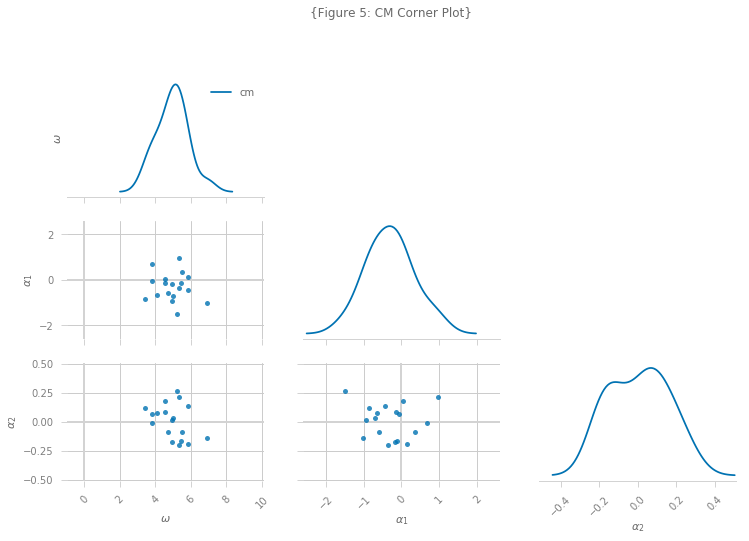

In [188]:
import matplotlib as plt


fig5 = figure(5, figsize=(12, 10))

clrs = sns.color_palette("colorblind")
zalpha=0.5
zlw=1

sns.set_palette(clrs)
crnplt2(cmmpem,'cm',mrange=slimrange,labs=matlabs,hist=HIST)

        
suptitle("{Figure 5: CM Corner Plot}")
if savefigs: savefig(figroot+"fig5_cm_corner.pdf",transparent=True)
#sns.kdeplot(cmmpem[:,-1],bw=0.2)

## 6: Bulk Data
- May want to look into contours
- Could also just show a subset of the areas
- will need to figure out how to present data from so many areas effectively
- needs adjusted R^2 for each area
- ANOVA plot (Dan will do that)

In [192]:
%%time
# load data
select = ["mld", "ov", "l2a", "l2b", "l1", "cm", "l3"]
crdata = {}

for s in select:
        res, mp = load_emdat(s,EOcut=0.2,CORcut=0.0,root='/home/tyler/dstrf_results/crcns/')
        crdata[s] = {"results": res,
                   "map": mp}

Error loading obla1305_6_EM-emcee
CPU times: user 860 ms, sys: 3.62 s, total: 4.48 s
Wall time: 21.9 s


86
31
42
29
12
24
33


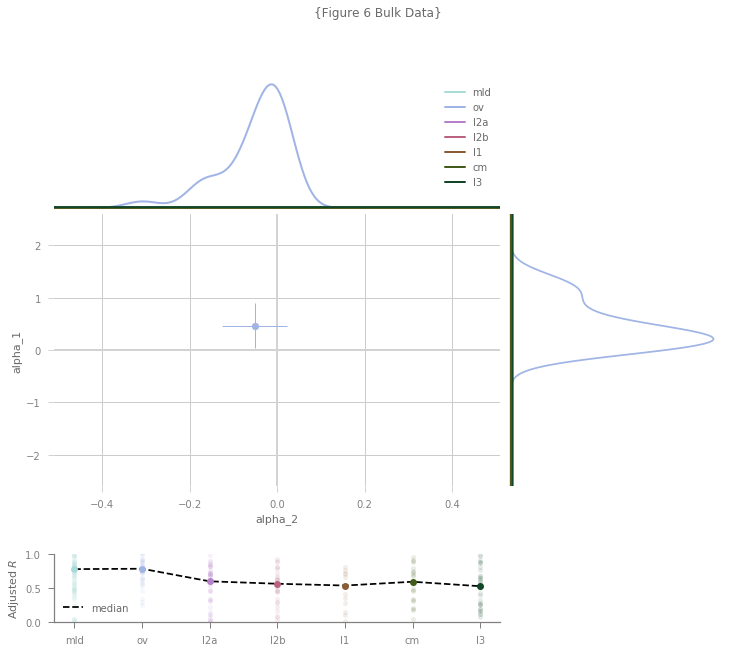

In [193]:
fig6 = figure(6, figsize=(12, 10))

gspec = gridspec.GridSpec(4, 2, wspace=0, hspace=0,
                                          height_ratios=[0.5,1,0.25,0.25],
                                          width_ratios=[1,0.5])
sns.set_palette(ch)
lnstys = ["-"]*7 + ["--","-."]
pntstys = ["o"]*7
for i,s in enumerate(select):
    #fig6 = figure(figsize=(12, 10))
    #gspec = gridspec.GridSpec(2, 2, wspace=0, hspace=0,height_ratios=[0.5,1],width_ratios=[1,0.5])
    ax = subplot(gspec[2])
    gridstyle(ax)
    ax.scatter(np.mean(crdata[s]["map"][:,2]),np.mean(crdata[s]["map"][:,1]),alpha=1,label=s,marker=pntstys[i],zorder=10)
    ax.errorbar(np.mean(crdata[s]["map"][:,2]),np.mean(crdata[s]["map"][:,1]),
                xerr=np.std(crdata[s]["map"][:,2]),yerr=np.std(crdata[s]["map"][:,1]),linewidth=1)
    #ax.hexbin(crdata[s]["map"][:,2],crdata[s]["map"][:,1],alpha=1,label=s,extent=(-0.5,0.5,-3,3),gridsize=20,cmap=maps[i],zorder=0)
    ax.set_ylim(slimrange[0][1])
    ax.set_xlim(slimrange[0][2])
    despine(ax,x=False,y=False)
    ax.set_ylabel("alpha_1")
    ax.set_xlabel("alpha_2")

    ax = subplot(gspec[0])
    gridstyle(ax,grid=False)
    sns.kdeplot(crdata[s]["map"][:,2],label=s, linestyle=lnstys[i],linewidth=2)
    despine(ax)
    ax.set_xlim(slimrange[0][2])
    legend()

    
    ax = subplot(gspec[3])
    gridstyle(ax, grid=False)
    sns.kdeplot(crdata[s]["map"][:,1],vertical=True, linestyle=lnstys[i])
    despine(ax)
    ax.set_ylim(slimrange[0][1])
    
    
ax = subplot(gspec[6])
meds = []
for i,s in enumerate(select):
    eo = [crdata[s]["results"][m]["corr"] / crdata[s]["results"][m]["eo"].tolist() for m in crdata[s]["results"]]
    ax.plot([i]*len(eo),eo,"o",alpha=0.1,markersize=5)
    print(len(eo))
    meds.append(np.median(eo))
    
ax.plot(meds,"--k",label="median")

for i,m in enumerate(meds):
    ax.plot([i],[m],"o")
    
ax.set_ylim(0,1)
ax.set_ylabel("Adjusted $R$")
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(select)
despine(ax,x=False,y=False)
legend()

suptitle("{Figure 6 Bulk Data}")
if savefigs: savefig(figroot+"fig6_crcns.pdf",transparent=True)

## Other
- add color bars to figure 2
- add spectrograms to first row of figure 2
- Table with all cells, areas, EO, R^2, aR2, omega, a1, a2

In [ ]:
import csv
savefile = "crcns_results.csv"
header = ["cell","region","w","a1","a2","corr","eo"]

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (110000, 110000))

with open(savefile,'w') as csvfile:
    writer =  csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for s in select:
        for k in crdata[s]["results"].keys():
            w1 = crdata[s]["results"][k]["w1"]
            corr = crdata[s]["results"][k]["corr"]
            eo = crdata[s]["results"][k]["eo"]
            writer.writerow([k,s,w1[0],w1[1],w1[2],corr,eo])
            
            
savefile = "modeldata_results.csv"
with open(savefile,'w') as csvfile:
    writer =  csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for s in models:
        for k in data[s]["results"].keys():
            w1 = data[s]["results"][k]["w1"]
            corr = data[s]["results"][k]["corr"]
            eo = data[s]["results"][k]["eo"]
            writer.writerow([k,s,w1[0],w1[1],w1[2],corr,eo])

In [ ]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

import matplotlib.colors as mcolors

crgb = mcolors.ColorConverter().to_rgb
cyan_map = make_colormap([(0,1,1),(0,0.2,0.2)])
magenta_map = make_colormap([crgb('white'),crgb("m")])
yellow_map = make_colormap([crgb('white'),crgb("y")])

cmyk_maps = [cyan_map,magenta_map,yellow_map]

cmyk = ["c","m","y","k"]

acmyk_maps = []
for cmap in cmyk_maps:

    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    #my_cmap[:int(cmap.N/3),-1] = 0

    # Create new colormap
    acmyk_maps.append(mcolors.ListedColormap(my_cmap))

In [ ]:
sns.heatmap(np.random.rand(50,50),cmap=cyan_map)

In [ ]:
ccolors = [(0.2,1,1),(0,0.6,0.6),(0,0.4,0.4)]
mcolors = [(0.2,1,1),(0,0.7,0.7),(0,0.4,0.4)]
ycolors = [(0.2,1,1),(0,0.7,0.7),(0,0.4,0.4)]

plot(np.sin(np.arange(0,20,0.1)),color=ccolors[0])
plot(np.sin(np.arange(10,30,0.1)),color=ccolors[0])
plot(np.sin(np.arange(20,40,0.1)),color=ccolors[0])
plot(np.sin(np.arange(30,50,0.1)),color=ccolors[0])